In [1]:
#J-JIT Complilation-Just in Time
#A-Automatic Differentiation
#X-XLA(Acclelerated Linear Algebra)

In [1]:
#JAX as NumPy
import jax
import jax.numpy as jnp
from jax import jit
a=jnp.array([1,2,3])
b=jnp.array([4,5,6])

print(a+b)
print(jnp.sqrt(a))
print(a.reshape(-1,1))
#but in jax array are immutable

[5 7 9]
[1.        1.4142135 1.7320508]
[[1]
 [2]
 [3]]


In [2]:
def myfunction(x):
    return jnp.where(x%2==0,x/2,3*x+1)


In [11]:
import time
arr=jnp.arange(10)
start=time.perf_counter()
myfunction(arr)
end=time.perf_counter()
print(end-start)

0.000547399977222085


In [17]:
import time
arr=jnp.arange(10)
start=time.perf_counter()
myfunction(arr).block_until_ready()
end=time.perf_counter()
print(end-start)

0.00025809998624026775


The difference between these two code snippets lies in JAX's lazy evaluation model. JAX uses Just-In-Time (JIT) compilation and asynchronous execution on GPUs/TPUs, meaning computations might not execute immediately when called.

### First Code:

- myfunction(arr) does not force immediate execution.
- JAX schedules the computation asynchronously (especially on GPUs/TPUs).
- time.perf_counter() captures the time before execution is actually complete.
- The reported time might be smaller than the actual execution time.
🔹 Issue: The function execution may still be running when the timer stops!

### Second Code:

- myfunction(arr) starts execution.
- .block_until_ready() forces JAX to complete the computation before proceeding.
- The timer only stops after all computations are actually finished.
- This gives the true execution time.

## Just-in-time compilation(JIT)

In [41]:
@jax.jit

c

arr = jnp.arange(10)

# Measure execution time
start = time.perf_counter()
result = myfunction(arr).block_until_ready()   # Normal execution
end = time.perf_counter()

print("Without jit:", result)
print("Execution Time:", end - start)


Without jit: [ 0.  4.  1. 10.  2. 16.  3. 22.  4. 28.]
Execution Time: 0.03771480009891093


In [45]:
myfunction_jit = jax.jit(myfunction)

start = time.perf_counter()
result_jit = myfunction_jit(arr).block_until_ready()  # JIT-compiled execution
end = time.perf_counter()

print("With jit:", result_jit)
print("Execution Time:", end - start)

With jit: [ 0.  4.  1. 10.  2. 16.  3. 22.  4. 28.]
Execution Time: 0.00038650003261864185


JAX provides the jax.jit (Just-In-Time compilation) decorator to speed up functions by compiling them with XLA (Accelerated Linear Algebra). This improves performance by optimizing computation and reducing Python overhead.

### Key Observations:
- First Call Overhead: The first time you call a JIT-compiled function, it takes longer because JAX compiles it.
- Subsequent Calls are Faster: After compilation, execution runs much faster since the function is now optimized.
- Automatic Vectorization: jax.jit enables parallel execution and fuses operations efficiently.

**Avoid jax.jit when:**

Your function involves Python loops, print statements, or control flow that changes shape dynamically.

In [47]:
print(jax.make_jaxpr(myfunction)(arr))

{ lambda ; a:i32[10]. let
    b:f32[10] = pjit[
      name=myfunction
      jaxpr={ lambda ; c:i32[10]. let
          d:i32[10] = pjit[
            name=remainder
            jaxpr={ lambda ; e:i32[10] f:i32[]. let
                g:i32[] = convert_element_type[new_dtype=int32 weak_type=False] f
                h:bool[] = eq g 0
                i:i32[] = pjit[
                  name=_where
                  jaxpr={ lambda ; j:bool[] k:i32[] l:i32[]. let
                      m:i32[] = select_n j l k
                    in (m,) }
                ] h 1 g
                n:i32[10] = rem e i
                o:bool[10] = ne n 0
                p:bool[10] = lt n 0
                q:bool[] = lt i 0
                r:bool[10] = ne p q
                s:bool[10] = and r o
                t:i32[10] = add n i
                u:i32[10] = select_n s n t
              in (u,) }
          ] c 2
          v:bool[10] = eq d 0
          w:f32[10] = convert_element_type[new_dtype=float32 weak_type=False]

### Automatic Differentiation 

In [37]:
from jax import grad

In [49]:
def square(x):
    return x ** 2

print(square(10.0))

100


In [51]:
print(grad(square)(10.0))

20.0


In [54]:
print(grad(grad(square))(10.0))

2.0


**Computing gradients in a linear logistic regression**

In [55]:
key = jax.random.key(7)

def sigmoid(x):
  return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
  return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [0.88, -1.08, 0.15],
                    [0.52, 0.06, -1.30],
                    [0.74, -2.49, 1.39]])
targets = jnp.array([True, False, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
  preds = predict(W, b, inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = jax.random.split(key, 3)
W = jax.random.normal(W_key, (3,))
b = jax.random.normal(b_key, ())

In [58]:
# Differentiate `loss` with respect to the first positional argument which is weight(W):
W_grad = grad(loss, argnums=0)(W, b)
print(f'{W_grad=}')

# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print(f'{W_grad=}')

# But you can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print(f'{b_grad=}')

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print(f'{W_grad=}')
print(f'{b_grad=}')

W_grad=Array([-0.5365673,  1.7310241, -2.2348125], dtype=float32)
W_grad=Array([-0.5365673,  1.7310241, -2.2348125], dtype=float32)
b_grad=Array(-0.7542623, dtype=float32)
W_grad=Array([-0.5365673,  1.7310241, -2.2348125], dtype=float32)
b_grad=Array(-0.7542623, dtype=float32)


We can also perform  gradient checking and raises an error if the gradients are incorrect.

In [66]:
from jax.test_util import check_grads

check_grads(loss, (W, b), order=2)

Now, this code will check if gradients of loss(W, b) are computed correctly up to the second order.

And if we change the order to 4 or more than it will throw error.

In [53]:
f = lambda x,y: x**2 + x + 4 + y**2

x=1.
y=2.

dfdx=grad(f,argnums=(0))
dfdy=grad(f,argnums=(1))
dfdx_dy=grad(f,argnums=(0,1))
result=dfdx_dy(x,y)
print(f(x,y),dfdx(x,y),dfdy(x,y))
print("Printing derivatives with respect to both x and y, use argnums=(0,1)",result[0].item() ,result[1].item())

10.0 3.0 4.0
Printing derivatives with respect to both x and y, use argnums=(0,1) 3.0 4.0


**Advanced automatic differentiation**

In [61]:
from jax import jacfwd, jacrev

def hessian(f):
    return (jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 2.)}')
print(f'Full Hessian = {hessian(f)(1.,2.)}')

Jacobian = (Array(3., dtype=float32, weak_type=True), Array(4., dtype=float32, weak_type=True))
Full Hessian = ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


### Automatic Vectorization

Automatic vectorization in JAX allows you to apply a function element-wise over batch dimensions efficiently, without writing explicit loops. This is done using jax.vmap, which transforms a function to operate on batches of inputs in parallel.

**Why Use jax.vmap?**
- Avoids writing explicit loops over batch dimensions.
- Efficiently utilizes hardware acceleration (TPUs, GPUs).
- Automatically optimizes execution for better performance.

In [67]:
def my_function(x):
    return jnp.where(x % 2 == 0, x / 2, 3 * x + 1)

x = jnp.array([1, 2, 3, 4, 5])

# Manually applying function to each element
output = jnp.array([my_function(xi) for xi in x])
print(output)


[ 4.  1. 10.  2. 16.]


Works, but uses an explicit loop, which is inefficient.

In [68]:
def my_function(x):
    return jnp.where(x % 2 == 0, x / 2, 3 * x + 1)

x = jnp.array([1, 2, 3, 4, 5])

# Automatically vectorizing the function
vectorized_function = jax.vmap(my_function)

# Apply function to the entire array
output = vectorized_function(x)
print(output)

[ 4.  1. 10.  2. 16.]


Faster and more efficient! JAX automatically applies the function over all elements.

If the batch dimension is not the first, you may use the in_axes and out_axes arguments to specify the location of the batch dimension in inputs and outputs. These may be an integer if the batch axis is the same for all inputs and outputs, or lists, otherwise.More you can read here https://dinocausevic.com/2023/06/13/jax-vmap/

In [64]:
import jax
import jax.numpy as jnp
from jax import vmap

# Define a dot product function
A = jnp.array([[1, 2, 3], [4, 5, 6]])   # Shape (2,3)
B = jnp.array([[7, 8, 9], [10, 11, 12]]) # Shape (2,3)

dot_product = lambda x, y: jnp.dot(x, y) 

batched_dot = vmap(dot_product,(1,1)) 
output = batched_dot(A, B)

print(output)  

A = jnp.array([[1, 2, 3], [4, 5, 6]])   # Shape (2,3)
B = jnp.array([[7, 8, 9], [10, 11, 12]]) # Shape (2,3)

batched_dot = vmap(dot_product,(0,0)) 
output = batched_dot(A, B)

print(output) 

[47 71 99]
[ 50 167]


In [18]:
A = jnp.array([[1, 2, 3], [4, 5, 6]])   # Shape (2,3)
B = jnp.array([[7, 8, 9], [10, 11, 12]]) # Shape (2,3)

batched_dot = vmap(dot_product,(1,1)) 
output = batched_dot(A, B)

print(output) 

[47 71 99]


In [65]:
A = jnp.array([[1, 2, 3], [4, 5, 6]])   # Shape (2,3)
B = jnp.array([[7, 8, 9], [10, 11, 12]]) # Shape (2,3)

batched_dot = vmap(dot_product,(None,0)) 
output = batched_dot(A, B)

print(output) 

[[ 50 122]
 [ 68 167]]


In [13]:
A = jnp.array([[1, 2, 3], [4, 5, 6]])   # Shape (2,3)
B = jnp.array([[7, 8, 9], [10, 11, 12],[13,14,15]]) # Shape (3,3)

batched_dot = vmap(dot_product,(0,None),0) 
output = batched_dot(A, B)

print(output)  


[[ 66  72  78]
 [156 171 186]]


In [9]:
A = jnp.array([[1, 2, 3], [4, 5, 6]])   # Shape (2,3)
B = jnp.array([[7, 8, 9], [10, 11, 12],[13,14,15]]) # Shape (3,3)

batched_dot = vmap(dot_product,(None,1),1) 
output = batched_dot(A, B)

print(output)  


[[ 66  72  78]
 [156 171 186]]


### Pseudorandom numbers

In [6]:
import jax

key=jax.random.key(7)
key

Array((), dtype=key<fry>) overlaying:
[0 7]

A key is an array with a special dtype corresponding to the particular PRNG implementation being used; in the default implementation each key is backed by a pair of uint32 values.

The key is effectively a stand-in for NumPy’s hidden state object, but we pass it explicitly to jax.random() functions. Importantly, random functions consume the key, but do not modify it: feeding the same key object to a random function will always result in the same sample being generated.

In [7]:
print(jax.random.normal(key))
print(jax.random.normal(key))

0.45123515
0.45123515


Re-using the same key, even with different random APIs, can result in correlated outputs, which is generally undesirable.

The rule of thumb is: never reuse keys (unless you want identical outputs).

JAX uses a modern Threefry counter-based PRNG that’s splittable. That is, its design allows us to fork the PRNG state into new PRNGs for use with parallel stochastic generation. In order to generate different and independent samples, you must split() the key explicitly before passing it to a random function:

In [8]:
for i in range(3):
  new_key, subkey = jax.random.split(key)
  del key  # The old key is consumed by split() -- we must never use it again.

  val = jax.random.normal(subkey)
  del subkey  # The subkey is consumed by normal().

  print(f"draw {i}: {val}")
  key = new_key  # new_key is safe to use in the next iteration.

draw 0: 0.4541335105895996
draw 1: 2.2433922290802
draw 2: 1.0064350366592407


(Calling del here is not required, but we do so to emphasize that the key should not be reused once consumed.)

jax.random.split() is a deterministic function that converts one key into several independent (in the pseudorandomness sense) keys. We keep one of the outputs as the new_key, and can safely use the unique extra key (called subkey) as input into a random function, and then discard it forever. If you wanted to get another sample from the normal distribution, you would split key again, and so on: the crucial point is that you never use the same key twice.

It doesn’t matter which part of the output of split(key) we call key, and which we call subkey. They are all independent keys with equal status. The key/subkey naming convention is a typical usage pattern that helps track how keys are consumed: subkeys are destined for immediate consumption by random functions, while the key is retained to generate more randomness later.

Usually, the above example would be written concisely as

In [10]:
.key, subkey = jax.random.split(key)

which discards the old key automatically. It’s worth noting that split() can create as many keys as you need, not just 2

In [11]:
keys=jax.random.split(key,5)

print(keys)

Array((5,), dtype=key<fry>) overlaying:
[[1655368132  475302476]
 [ 400014582 1736700117]
 [1856950286 2089119175]
 [4124452448  828469155]
 [2409566084 2032918171]]


### Pytrees

A pytree is a container-like structure built out of container-like Python objects — “leaf” pytrees and/or more pytrees. A pytree can include lists, tuples, and dicts. A leaf is anything that’s not a pytree, such as an array, but a single leaf is also a pytree.

In JAX, you can use jax.tree.leaves(), to extract the flattened leaves from the trees, as demonstrated here:

In [11]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Print how many leaves the pytrees have.
for pytree in example_trees:
  # This `jax.tree.leaves()` method extracts the flattened leaves from the pytrees.
  leaves = jax.tree.leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x000001E3E63316E0>] has 3 leaves: [1, 'a', <object object at 0x000001E3E63316E0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


**jax.tree.map**

jax.tree_map is a  function in JAX that applies a function element-wise to all leaves of a PyTree (nested structure). It is similar to Python's map(), but works on nested data structures like lists, tuples, and dictionaries.

In [13]:
tree = {'a': jnp.array([1, 2, 3]), 'b': [4, 5, 6]}
result = jax.tree.map(lambda x: x * 2, tree)

print(result)

{'a': Array([2, 4, 6], dtype=int32), 'b': [8, 10, 12]}


**Extending PyTrees with jax.tree_util.register_pytree_node() and jax.tree_map()**

JAX provides PyTrees (nested data structures) to handle complex data efficiently. By default, JAX treats Python structures like lists, tuples, dictionaries, and NumPy arrays as PyTrees.

However, custom classes are not automatically recognized as PyTrees.
To extend JAX's PyTree system for a custom class, we use:

jax.tree_util.register_pytree_node() → Registers a custom object as a PyTree.
jax.tree_map() → Applies a function to PyTree leaves.

In [15]:
class Special(object):
  def __init__(self, x, y):
    self.x = x
    self.y = y

jax.tree.leaves([
    Special(0, 1),
    Special(2, 4),
])

[<__main__.Special at 0x1e3e482cb90>, <__main__.Special at 0x1e3e6b4ff10>]

In [16]:
from jax.tree_util import register_pytree_node

class RegisteredSpecial(Special):
  def __repr__(self):
    return "RegisteredSpecial(x={}, y={})".format(self.x, self.y)

def special_flatten(v):
  """Specifies a flattening recipe.

  Params:
    v: The value of the registered type to flatten.
  Returns:
    A pair of an iterable with the children to be flattened recursively,
    and some opaque auxiliary data to pass back to the unflattening recipe.
    The auxiliary data is stored in the treedef for use during unflattening.
    The auxiliary data could be used, for example, for dictionary keys.
  """
  children = (v.x, v.y)
  aux_data = None
  return (children, aux_data)

def special_unflatten(aux_data, children):
  """Specifies an unflattening recipe.

  Params:
    aux_data: The opaque data that was specified during flattening of the
      current tree definition.
    children: The unflattened children

  Returns:
    A reconstructed object of the registered type, using the specified
    children and auxiliary data.
  """
  return RegisteredSpecial(*children)

# Global registration
register_pytree_node(
    RegisteredSpecial,
    special_flatten,    # Instruct JAX what are the children nodes.
    special_unflatten   # Instruct JAX how to pack back into a `RegisteredSpecial`.
)

In [17]:
jax.tree.map(lambda x: x + 1,
  [
   RegisteredSpecial(0, 1),
   RegisteredSpecial(2, 4),
  ])

[RegisteredSpecial(x=1, y=2), RegisteredSpecial(x=3, y=5)]

### Gotcha #1: Pure functions
- JAX is designed to work only on pure functions!

A pure function is a function that satisfies the following two properties:

- No Side Effects – The function does not modify any external state (e.g., global variables, I/O operations, database writes).
- Deterministic Output – For the same input, the function always produces the same output.

**Why Does JAX Require Pure Functions?**

JAX uses just-in-time (JIT) compilation and automatic differentiation. If functions have side effects, JAX cannot safely optimize or parallelize computations.

In [5]:
#Example 1

def impure_print_side_effect(x):
    print("Executing function") # Side effect: printing
    return x

# The side-effects appear during the first run 
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compiled version of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


In [6]:
# Example 2

g = 0.

def impure_uses_globals(x):
    return x + g # Modifies external variable

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global!
g = 10.

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

First call:  4.0
Second call:  5.0
Third call, different type:  [14.]


### Gotcha #2: In-Place Updates


In [7]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)

print("original array unchanged:\n", jax_array)
print("updated array:\n", updated_array)

# If this seems wasteful to you, congrats, you did some algorithms/data structures in your life. ;)
# The thing is - inside jit-compiled code, if the input value x of x.at[idx].set(y) 
# is not reused, the compiler will optimize the array update to occur in-place!

original array unchanged:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


### Gotcha #3: Out-of-Bounds Indexing
Due to JAX's accelerator agnostic approach JAX had to make a non-error behaviour for out of bounds indexing (similarly to how invalid fp arithmetic results in NaNs and not an exception).

In [9]:
# NumPy behavior
import numpy as np 
try:
  np.arange(10)[11]
except Exception as e:
    print("Exception {}".format(e))

Exception index 11 is out of bounds for axis 0 with size 10


In [10]:
# JAX behavior
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11])  # example of 2)

[0 1 2 3 4 5 6 7 8 9]
9


### Stateful computations

JAX transformations like jit(), vmap(), grad(), require the functions they wrap to be pure: that is, functions whose outputs depend solely on the inputs, and which have no side effects such as updating of global state.

In [1]:
import jax
import jax.numpy as jnp

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


The counter’s n attribute maintains the counter’s state between successive calls of count. It is modified as a side effect of calling count.

Let’s say we want to count fast, so we JIT-compile the count method.

In [8]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


Oh no! Our counter isn’t working. This is because the line:

self.n += 1

in count involves a side effect: it modifies the input counter in-place, and so this function is not supported by jit. Such side effects are executed only once when the function is first traced, and subsequent calls will not repeat the side effect.


**The solution: explicit state**

In [9]:
CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as 
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


In this new version of Counter, we moved n to be an argument of count, and added another return value that represents the new, updated, state. To use this counter, we now need to keep track of the state explicitly. But in return, we can now safely jax.jit this counter:

In [10]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


**A general strategy**

We can apply the same process to any stateful method to convert it into a stateless one. We took a class of the form

In [ ]:
class StatefulClass

  state: State

  def stateful_method(*args, **kwargs) -> Output:

and turned it into a class of the form

In [ ]:
class StatelessClass

  def stateless_method(state: State, *args, **kwargs) -> (Output, State):

### Taining a toy MLP (multi-layer perceptron) model

In [8]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

def init_mlp_params(layer_widths):
    params = []

    # Allocate weights and biases (model parameters)
    # Notice: we're not using JAX's PRNG here - doesn't matter for this simple example
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                biases=np.ones(shape=(n_out,))
        )
    )

    return params

# Instantiate a single input - single output, 3 layer (2 hidden layers) deep MLP
params = init_mlp_params([1, 128, 128, 1])

# Another example of how we might use tree_map - verify that shapes make sense:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [9]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)  # MSE loss

lr = 0.0001

@jit  # notice how we do jit only at the highest level - XLA will have plenty of space to optimize
def update(params, x, y):

    # Note that grads is a pytree with the same structure as params.
    # grad is one of the many JAX functions that has built-in support for pytrees!
    grads = jax.grad(loss_fn)(params, x, y)

    # SGD update
    return jax.tree_map(
        lambda p, g: p - lr * g, params, grads  # for every leaf i.e. for every param of MLP
    )
     

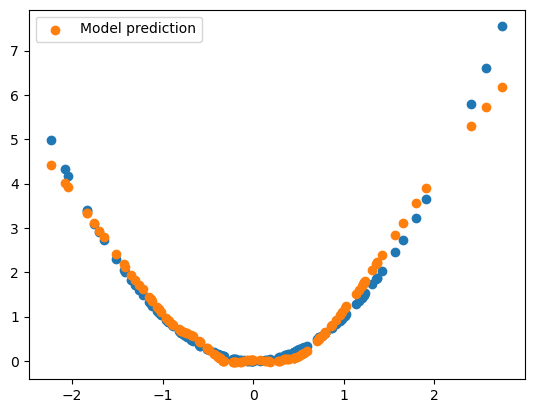

In [10]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2  # let's learn how to regress a parabola

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)  # again our lovely pattern

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();